# My Approach:
1.Initial Inspection:
When I first looked at the dataset, I noticed it wasn’t just face images. There were some vector graphics and images with letters that didn’t make sense to include.
I manually went through and removed those, assuming they’d reduce the model’s accuracy if I left them in.

2.Face Detection and Cropping:
Next, I focused on identifying faces in the images. I cropped out the faces and saved the processed images in a folder called "Processed Data".

3.Splitting the Dataset:
Once I had the clean dataset, I split it into training and testing sets. The training set went into a folder named "Train Data" and the testing set into "Test Data".

4.Preparing the Data:
I loaded the dataset and organized it into a DataFrame with two columns: ['image', 'label']. This made it easier to work with.

5.Analyzing the Data:
During analysis, I noticed something important: the dataset was imbalanced. For example, the "Sad" class had way fewer images compared to other classes.

6.Fixing Class Imbalance:
To address this, I performed data augmentation specifically for the "Sad" class. This helped balance the dataset.
After that, I extracted features from the newly balanced dataset to prepare it for training. But this didn't perform well in the predictions(This Code cell is commented).

So instead of that, I calculate class weights and train the model. This will assign higher weights to samples from underrepresented classes during training. Which lead model to give better predictions.

7.Building and Training the Model:
I created a CNN model and trained it on the balanced dataset.
Once training was done, I plotted some graphs to visualize how the model was performing.

8.Testing the Model:
Finally, I added a "Test with Image Data" section where you can test images and see the model’s predictions.

# Data Preprocessing

In [3]:
##Cropping Faces and save the images in folders
def Crop_and_save(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    image_count = len(os.listdir(input_folder))
    processed_images = 0

    for filename in os.listdir(input_folder):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path)

            detector = MTCNN()
            faces = detector.detect_faces(image)

            for i, face in enumerate(faces):
                x, y, w, h = face['box']
                cropped_face = image[y:y+h, x:x+w]
                output_path = os.path.join(output_folder, f"{filename}_{i}.jpg")
                cv2.imwrite(output_path, cropped_face)

            processed_images += 1
            print(f"Processing... {processed_images}/{image_count}")

##Change the folder locations and crop the 3 class images
input_folder = 'Data/Sad'
output_folder = 'Processed Data/Sad'
Crop_and_save(input_folder, output_folder)

Num GPUs Available:  0
Processing... 1/52
Processing... 2/52
Processing... 3/52
Processing... 4/52
Processing... 5/52
Processing... 6/52
Processing... 7/52
Processing... 8/52
Processing... 9/52
Processing... 10/52
Processing... 11/52
Processing... 12/52
Processing... 13/52
Processing... 14/52
Processing... 15/52
Processing... 16/52
Processing... 17/52
Processing... 18/52
Processing... 19/52
Processing... 20/52
Processing... 21/52
Processing... 22/52
Processing... 23/52
Processing... 24/52
Processing... 25/52
Processing... 26/52
Processing... 27/52
Processing... 28/52
Processing... 29/52
Processing... 30/52
Processing... 31/52


MemoryError: Unable to allocate 1.73 GiB for an array with shape (15229, 15229) and data type float64

In [33]:
import os
import shutil
from sklearn.model_selection import train_test_split

##Separate the Cropped images to Test set and Train set
def split_dataset(source_dir, train_dir, test_dir, test_size=0.3):

    for class_name in os.listdir(source_dir):
        class_dir = os.path.join(source_dir, class_name)
        image_files = os.listdir(class_dir)
    
        train_files, test_files = train_test_split(image_files, test_size=test_size)

        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True) 

        ## Copy the images to the test and train folders
        for file in train_files:
            src_file = os.path.join(class_dir, file)
            dst_file = os.path.join(train_class_dir, file)
            shutil.copy(src_file, dst_file)
    
        for file in test_files:
            src_file = os.path.join(class_dir, file)
            dst_file = os.path.join(test_class_dir, file)
            shutil.copy(src_file, dst_file)

source_dir = "Processed Data"
train_dir = "Train Data"
test_dir = "Test Data"

split_dataset(source_dir, train_dir, test_dir)

# Load the Dataset

In [34]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [35]:
TRAIN_DIR = 'Test Data/'
TEST_DIR = 'Test Data/'

In [36]:

def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [37]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

Angry Completed
Happy Completed
Sad Completed


,image,label
0,Test Data/Angry\angry-people-screaming-group-m...,Angry
1,Test Data/Angry\angry-fury-screaming-people-gr...,Angry
2,Test Data/Angry\Angry-people-2.jpg_2.jpg,Angry
3,Test Data/Happy\guilherme-stecanella-375176-un...,Happy
4,Test Data/Happy\goup-happy-people-35582464.jpg...,Happy


In [38]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

Angry Completed
Happy Completed
Sad Completed


,image,label
0,Test Data/Angry\439-4398363_angry-man-png-pict...,Angry
1,Test Data/Angry\5cd88fd321000035007f6cd2.jpeg_...,Angry
2,Test Data/Angry\anger-18615_640.jpg_0.jpg,Angry
3,Test Data/Angry\angry-complaining-group-busine...,Angry
4,Test Data/Angry\angry-complaining-group-busine...,Angry


# Data Analysis

<Axes: xlabel='count', ylabel='label'>

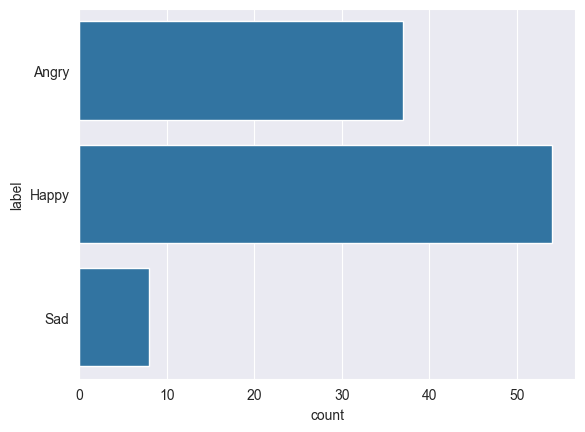

In [39]:
sns.countplot(train['label'])

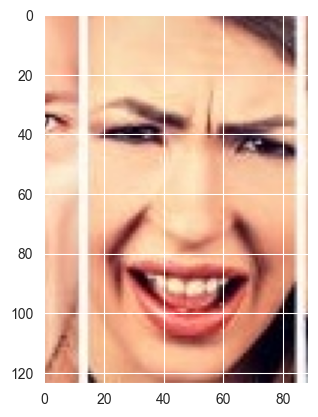

In [40]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img);

# Feature Extraction

Angry Completed
Happy Completed
Sad Completed
Angry Completed
Happy Completed
Sad Completed


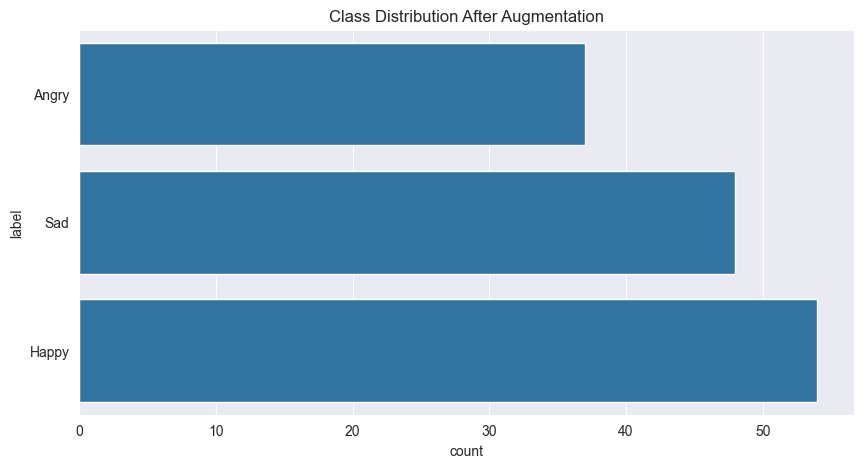

In [11]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# 
# ## Handel class imbalance caused by Sad class
# def augment_minority_classes(train_df, minority_class='Sad', augmentation_factor=5):
#     
#     augmented_images = []
#     augmented_labels = []
#     
#     ## Data augmentation generator
#     datagen = ImageDataGenerator(
#         rotation_range=20,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest'
#     )
#     
#     ## select Sad class
#     sad_images = train_df[train_df['label'] == minority_class]
#     
#     ## Augment Sad class images
#     for img_path in sad_images['image']:
#         # Load and preprocess the image
#         img = Image.open(img_path)
#         img = img.resize((48, 48))
#         img_array = np.array(img)
#         img_array = img_array.reshape((1, 48, 48, 3))
#         
#         
#         i = 0
#         for batch in datagen.flow(img_array, batch_size=1):
#             # Save the augmented image to a file
#             augmented_img_path = img_path.replace('.', f'_aug_{i}.')
#             Image.fromarray(batch[0].astype('uint8')).save(augmented_img_path)
#             
#             augmented_images.append(augmented_img_path)
#             augmented_labels.append(minority_class)
#             
#             i += 1
#             if i >= augmentation_factor:
#                 break
#     
#     ## Create dataframe
#     augmented_df = pd.DataFrame({
#         'image': augmented_images,
#         'label': augmented_labels
#     })
#     
#     balanced_df = pd.concat([train_df, augmented_df], ignore_index=True)
#     
#     return balanced_df
# 
# def extract_features(images, target_size=(48, 48)):
#     features = []
#     for image_path in tqdm(images):
#         if image_path is not None:
#             img = Image.open(image_path)
#             img = img.resize(target_size)  ## Resize the image
#             img = np.array(img)
#             features.append(img)
#         else:
#             # For augmented images, generate a random image
#             img = np.random.randint(0, 256, (48, 48, 3), dtype=np.uint8)
#             features.append(img)
#     features = np.array(features)
#     features = features.reshape(len(features), 48, 48, 3)
#     return features
# 
# train = pd.DataFrame()
# train['image'], train['label'] = load_dataset(TRAIN_DIR)
# 
# train = augment_minority_classes(train)
# train = train.sample(frac=1).reset_index(drop=True)
# 
# test = pd.DataFrame()
# test['image'], test['label'] = load_dataset(TEST_DIR)
# 
# ## Class distribution after augmentation
# plt.figure(figsize=(10, 5))
# sns.countplot(train['label'])
# plt.title('Class Distribution After Augmentation')
# plt.show()


In [41]:
import numpy as np
from PIL import Image

def extract_features(images, target_size=(48, 48)):
    features = []
    for image_path in tqdm(images):
        img = Image.open(image_path)
        img = img.resize(target_size)  ## Resize the image
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 3)
    return features

In [42]:
train_features = extract_features(train['image'])

  0%|          | 0/99 [00:00<?, ?it/s]

In [43]:
test_features = extract_features(test['image'])

  0%|          | 0/99 [00:00<?, ?it/s]

In [44]:
## normalizing 
x_train = train_features/255.0
x_test = test_features/255.0

In [45]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [46]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [47]:
y_train[0]

array([1., 0., 0., 0., 0., 0., 0.])

In [48]:
input_shape = (48, 48, 3)
output_class = 7

# Model Creation

In [49]:
model = Sequential()
## convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(48, 48, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
## fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
## output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(np.argmax(y_train, axis=1)), 
    y=np.argmax(y_train, axis=1)
)

class_weights = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit(
    x=x_train, 
    y=y_train, 
    batch_size=128, 
    epochs=100, 
    validation_data=(x_test, y_test),
    class_weight=class_weights
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1212 - loss: 2.0511 - val_accuracy: 0.5455 - val_loss: 1.5698
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step - accuracy: 0.5657 - loss: 1.5496 - val_accuracy: 0.3737 - val_loss: 1.5016
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step - accuracy: 0.3636 - loss: 1.3316 - val_accuracy: 0.3737 - val_loss: 1.4888
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step - accuracy: 0.3535 - loss: 1.2599 - val_accuracy: 0.0808 - val_loss: 1.4293
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step - accuracy: 0.2929 - loss: 1.2338 - val_accuracy: 0.5354 - val_loss: 1.3885
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step - accuracy: 0.4141 - loss: 1.1743 - val_accuracy: 0.5455 - val_loss: 1.3673
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step - accuracy: 0.4646 - loss: 1.1570 - val_accuracy: 0.3737 - val_loss: 1.3548
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step - accuracy: 0.4444 - loss: 1.1454 - val_accuracy: 0.3737 - val_

# Plot the Results

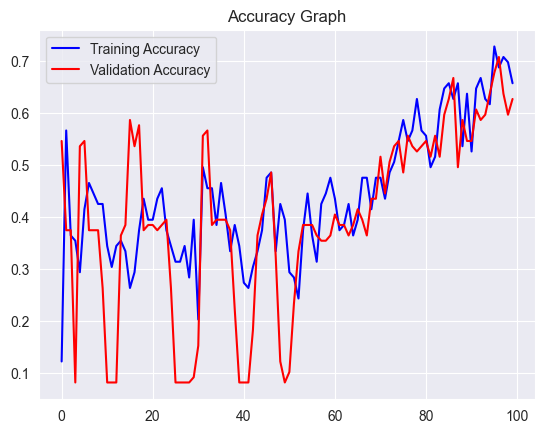

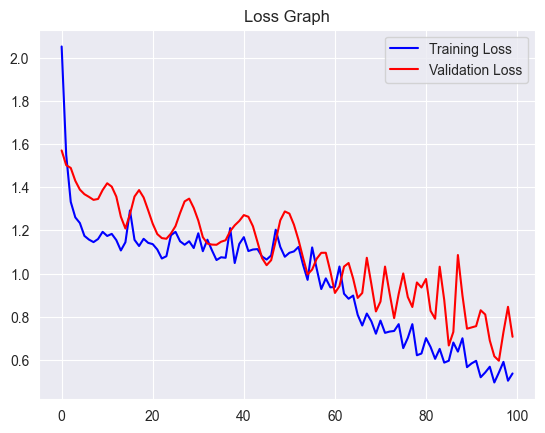

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

# Test with Image Data

Original Output: Angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Predicted Output: Angry


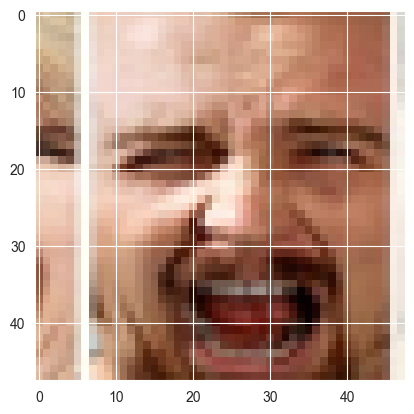

In [52]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])

## Reshape the image 
img = x_test[image_index].reshape(1, 48, 48, 3)
pred = model.predict(img)
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)

plt.imshow(x_test[image_index])
plt.show()

In [53]:
## Save the model
model.save('my_emotion_model.keras')

In [58]:
import cv2
from mtcnn import MTCNN
from tensorflow.keras.models import load_model
import numpy as np

## Load the model
model = load_model('my_emotion_model.keras')
le = LabelEncoder()
le.fit(['Angry', 'Happy', 'Sad'])

def predict_emotions_from_group_image(image_path, model, le):
    img = cv2.imread(image_path)

    ## Detect faces using MTCNN
    detector = MTCNN()
    faces = detector.detect_faces(img)

    for face in faces:
        x, y, w, h = face['box']
        face_img = img[y:y+h, x:x+w]

        face_img = cv2.resize(face_img, (48, 48))
        face_img = face_img / 255.0

        ##  prediction
        prediction = model.predict(np.expand_dims(face_img, axis=0))
        predicted_class_index = np.argmax(prediction)
        predicted_class = le.inverse_transform([predicted_class_index])[0]
        confidence_level = prediction[0][predicted_class_index] * 100

        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(img, f"{predicted_class} ({confidence_level:.2f}%)", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    cv2.imshow("Image with Predictions", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

##Test a image other than the data set
image_path = "Actual Test Images/12.jpg"
predict_emotions_from_group_image(image_path, model, le)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
